# Lab9 - Spatial Data Analysis
#### Exploratory spatial data analysis of CitiBike data using pysal and geopandas
#### Guest Lecture by Prof. Sina Kashuk (sina@datakind.org)

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

## Import initial libraries

In [54]:
%matplotlib inline
import numpy as np
import pandas as pd
import os
import datetime as dt
from pandas import DataFrame
import matplotlib.pylab as plt
import statsmodels.api as sm
import pysal as ps

## Working with Shape File

### Loading Census Tract Shape File¶

In [5]:
from geopandas import GeoDataFrame
shape_path="Data/CT_Shape/ct_shape.shp"
ct_shape = GeoDataFrame.from_file(shape_path)
ct_shape.index=ct_shape.BoroCT2010

In [6]:
ct_shape.head()

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry
BoroCT2010,,,,,,,,,,,,
5000900,5000900,5,Staten Island,I,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016729,POLYGON ((-74.07920577013245 40.64343078374566...
5012500,5012500,5,Staten Island,I,012500,125,SI22,West New Brighton-New Brighton-St. George,3903,4.954936e+06,10582.855530,POLYGON ((-74.11618948747538 40.62894119691981...
5013301,5013301,5,Staten Island,E,013301,133.01,SI22,West New Brighton-New Brighton-St. George,3903,7.217847e+05,3428.312676,POLYGON ((-74.11719947139957 40.63456809812987...
5019700,5019700,5,Staten Island,I,019700,197,SI07,Westerleigh,3903,3.231720e+06,9097.697226,POLYGON ((-74.13122302263596 40.61726518212697...
5002002,5002002,5,Staten Island,I,002002,20.02,SI14,Grasmere-Arrochar-Ft. Wadsworth,3902,8.501224e+06,12591.725901,"POLYGON ((-74.0635056566019 40.60215005483046,..."


### Coordinate systems, projections, and transformations 

In [7]:
from fiona.crs import from_epsg
#fiona takes care of crs - coordinate reference system.
ct_shape.crs = from_epsg(4326) # epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet
NYC_Area=ct_shape.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet

total NYC land area: 302.3 (mi^2)


### Visualize the Cencus Tract boundaries colored by boroughs

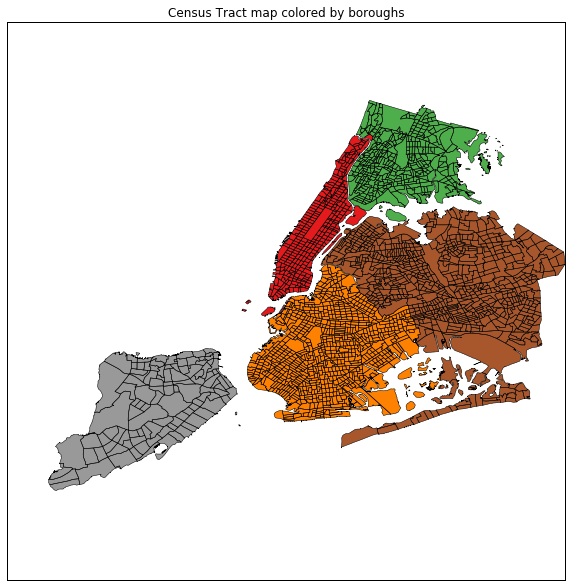

In [8]:
f, ax = plt.subplots(figsize=(10,10))
  # 10,10 gives the boundary of the plot
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape.plot(column='BoroCode',alpha=1,linewidth=0.5,ax=ax)
plt.title("Census Tract map colored by boroughs")

### Figure 1 - Greater New York City - Population Census Tract 2010 Map. Color coded for the 5 boroughs.

### Map NYC Population density

#### Load Census Data for 2010

In [9]:
ct_data=DataFrame.from_csv('Data/ACS_CT2010.csv')
#set index to be the BoroCT2010 code
ct_data.index=ct_data.BoroCT2010.astype(str)

#### Add popuation density to CT shapefile

In [10]:
# Population density joined with Shape file
ct_shape_pop=ct_shape.join(ct_data[['SE_T002_002']]) #SE_T002_002 is population density in social explorer dataset

#### Vusualize the Population density for 2010

/opt/rh/anaconda/root/lib/python2.7/site-packages/geopandas/plotting.py:225: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  "(for consistency with matplotlib)", FutureWarning)


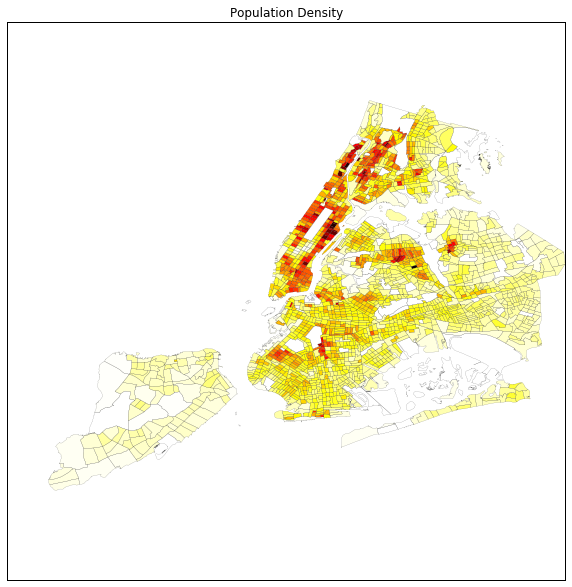

In [11]:
f, ax = plt.subplots(figsize=(10,10))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ct_shape_pop.plot(column='SE_T002_002',colormap='hot_r',alpha=1,linewidth=0.1,ax=ax)
plt.title("Population Density")

### Figure 2 - Population Density of the Greater New York City. Red denotes high population density and light yellow denotes sparse density.

## Explore CitiBike data

### Load CitiBike data

In [12]:
df_bike_monthly=DataFrame.from_csv('Data/CitiBike_monthly_byStation.csv')
df_bike_monthly.head()

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0
2013-10-31,2920,4409,10456,3520,8928,3237,2530,3909,4169,2542,...,0,0,0,0,0,0,0,0,0,0
2013-11-30,1883,2731,6384,2446,5201,2085,1415,2727,3146,1539,...,0,0,0,0,0,0,0,0,0,0


### Above data says No. of pickups from pickup stations 1000,1001,... for the different dates.

### Time Series Aanalysis

In [14]:
# Create a copy of the df for the visualization purposes
df_bike_monthly1 = df_bike_monthly.copy()
df_bike_monthly1.index = df_bike_monthly1.index.strftime("%B %Y")
df_bike_monthly1.index

Index([u'July 2013', u'August 2013', u'September 2013', u'October 2013',
       u'November 2013', u'December 2013', u'January 2014', u'February 2014',
       u'March 2014', u'April 2014', u'May 2014', u'June 2014', u'July 2014',
       u'August 2014', u'September 2014', u'October 2014', u'November 2014',
       u'December 2014', u'January 2015', u'February 2015', u'March 2015',
       u'April 2015', u'May 2015', u'June 2015', u'July 2015', u'August 2015',
       u'September 2015', u'October 2015', u'November 2015', u'December 2015',
       u'January 2016', u'February 2016', u'March 2016', u'April 2016',
       u'May 2016', u'June 2016'],
      dtype='object')

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


(-200, 16000)

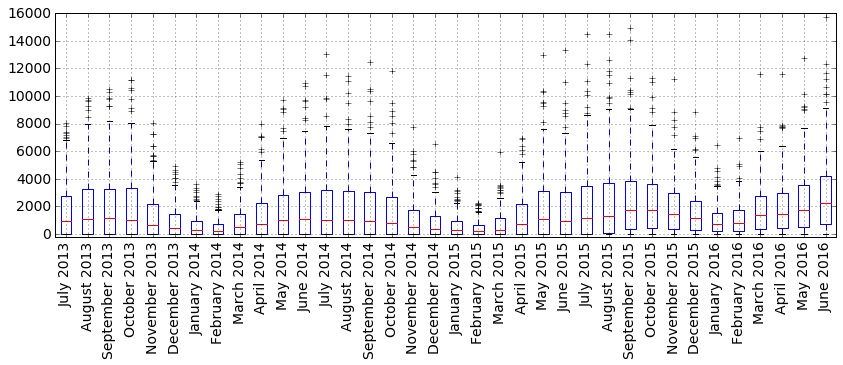

In [10]:
# Creating Box Plots >>>
plt.rcParams['font.size']=14
f, ax = plt.subplots(figsize=(14,4))

df_bike_monthly_.T.boxplot(figsize=(15,7),ax = ax,rot=90);
ax.set_ylim([-200,16000])

# Periodic data, Seasonality

### Figure 3 - Boxplot for bike usage across different months. It is observed that the data is periodic around the summer and winter seasons of the years.

#### Seasonal Decomposition   -    Seasonal Pattern

/usr/local/lib/python2.7/site-packages/statsmodels/tsa/filters/filtertools.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return np.r_[[np.nan] * head, x, [np.nan] * tail]


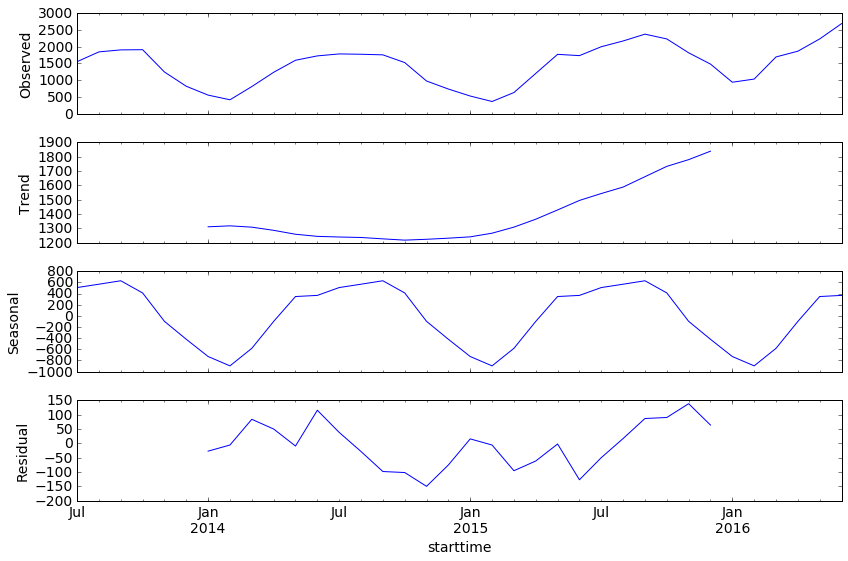

In [11]:
# Create a monthly time series of bike ride (Average of all citibike stations)
df_new=df_bike_monthly.mean(1).resample('M').mean()
df_new.interpolate(inplace=True)

# Seasonal Decomposition using statsmodels api
res = sm.tsa.seasonal_decompose(df_new.dropna())
plt.rcParams['figure.figsize']=(12,8)
resplot = res.plot()

# Plot 2,3,4 > Yearly trend, Seasonal trend and Residual.

### Figure 4 - Monthly time series of bike ride (Average of all citibike stations).
### Trends - Observed, Yearly, Seasonal and Residual trend

## Map CitiBike Data to CT level

### Load CitiBike station location data

In [16]:
station_id=DataFrame.from_csv('Data/Station_id.csv')
#convert station_ids to string index
station_id.index=station_id.index.astype(str)
station_id.head()

,lat,lon
1000,40.753231,-73.970325
1001,40.749718,-74.002950
1002,40.730287,-73.990765
1003,40.718939,-73.992663
1004,40.734927,-73.992005


### Create CitiBike station Geometry (Point) from Corrdinates (Lat & Lon)

In [17]:
import shapely
# combine lat and lon to one column
station_id['lonlat']=zip(station_id.lon,station_id.lat)
# Create Point Geometry based on lonlat column
station_id['geometry']=station_id[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
# lat and lon are numbers, to plot them, we convert them to Points using shapely library.
# In this case, shape file is only a point but it has geometry associated with it.
station_id.head()

,lat,lon,lonlat,geometry
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098)
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753)
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666)
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904)
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695)


### Intersect the two geometries

In [18]:
ct_shape[ct_shape.geometry.intersects(station_id.iloc[1].geometry)].BoroCT2010.values

array([u'1009900'], dtype=object)

In [21]:
# Intersect the points and the census tracks
# a is a vector added to new column to station_id-BoroCT2010
a = []
# check for each citibike stations to see what CT they are belong to
for i in range(len(station_id)):
    a.append(ct_shape[ct_shape.geometry.intersects(station_id.iloc[i].geometry)].BoroCT2010.values[0])
    # ct_shape.geometry.intersects(station_id.iloc[i].geometry) >> Creates a mask
    print '\r',"%",str((i+1)*100./len(station_id))[:4],
station_id['BoroCT2010'] = a

% 100.


In [22]:
station_id.BoroCT2010.head()

1000    1009000
1001    1009900
1002    1005700
1003    1001800
1004    1006100
Name: BoroCT2010, dtype: object

### Add Monthly, Summer and Winters rides to the station GeoDataFrame with CT code

In [25]:
df_bike_monthly.index.month

array([ 7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,
       12,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2,  3,  4,
        5,  6], dtype=int32)

In [31]:
df_bike_monthly.head(3)

,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,...,1533,1534,1535,1536,1537,1538,1539,1540,1541,1542
starttime,,,,,,,,,,,,,,,,,,,,,
2013-07-31,2343,3914,6979,2750,4914,2229,2183,3139,3622,2368,...,0,0,0,0,0,0,0,0,0,0
2013-08-31,2696,4429,9020,3433,6645,2768,2761,3422,4271,2910,...,0,0,0,0,0,0,0,0,0,0
2013-09-30,2878,5258,9814,3739,7837,3206,2747,3590,4618,2885,...,0,0,0,0,0,0,0,0,0,0


In [45]:
# Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
station_id['MonthlyAve'] = df_bike_monthly.sum()

In [46]:
### Create average monthly rides column from monthly citibike data and add it to the station id which has the geometry
# Summer months are 6 months from March to August
# Winter months are 6 months from September to February
station_id['Summer'] = df_bike_monthly[(df_bike_monthly.index.month > 2) & (df_bike_monthly.index.month < 9)].sum()
station_id['Winter'] = df_bike_monthly[(df_bike_monthly.index.month < 3) | (df_bike_monthly.index.month > 8)].sum()

In [27]:
station_id.head()

,lat,lon,lonlat,geometry,BoroCT2010,Summer,Winter
1000,40.753231,-73.970325,"(-73.97032517, 40.75323098)",POINT (-73.97032517 40.75323098),1009000,37811,31497
1001,40.749718,-74.002950,"(-74.002950346, 40.749717753)",POINT (-74.00295034600001 40.749717753),1009900,59289,43535
1002,40.730287,-73.990765,"(-73.9907647, 40.73028666)",POINT (-73.9907647 40.73028666),1005700,154020,119505
1003,40.718939,-73.992663,"(-73.99266288, 40.71893904)",POINT (-73.99266288 40.71893904),1001800,57679,44270
1004,40.734927,-73.992005,"(-73.99200509, 40.73492695)",POINT (-73.99200509000001 40.73492695),1006100,102895,81149


### Add the monthly, summer and winter average rides to the CT shapefile 

In [47]:
# Summer Ride Counts
temp = station_id[['MonthlyAve']]
temp_summer = station_id[['Summer']]
temp_winter = station_id[['Winter']]

temp['station_id'] = station_id.index
temp_summer['station_id'] = station_id.index
temp_winter['station_id'] = station_id.index

temp.index = station_id['BoroCT2010']
temp_summer.index = station_id['BoroCT2010']
temp_winter.index = station_id['BoroCT2010']

ct_shape_MonthlyAve = ct_shape.join(temp)
ct_shape_MonthlyAve_Summer = ct_shape.join(temp_summer)
ct_shape_MonthlyAve_Winter = ct_shape.join(temp_winter)

ct_shape_MonthlyAve.fillna(0,inplace=True)
ct_shape_MonthlyAve_Winter.fillna(0,inplace=True)
ct_shape_MonthlyAve_Summer.fillna(0,inplace=True)

/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

### Map the monthly, summer and winter rides. Zoomed in to the color coded focus area of the city.

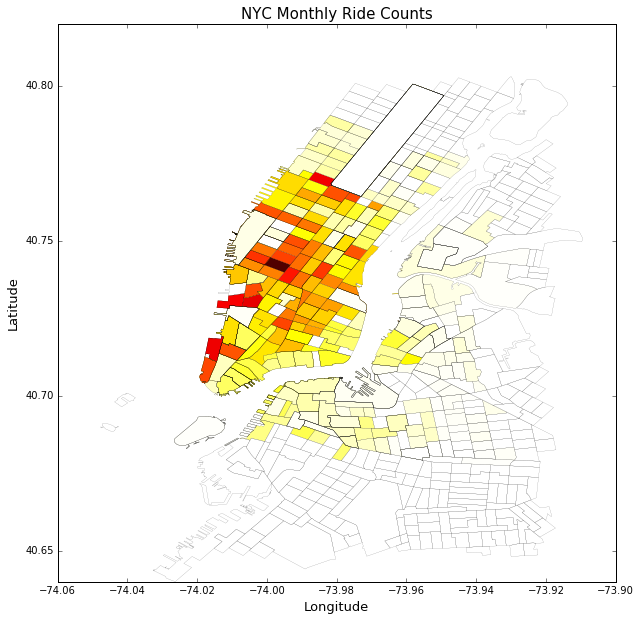

In [52]:
f, ax = plt.subplots(figsize=(10,10))

ct_shape_MonthlyAve_Zoom=(ct_shape_MonthlyAve[ct_shape_MonthlyAve
                           .centroid
                           .apply(lambda c:c.x>-74.1 and 
                                  c.x<-73.92 and 
                                  c.y>40.65 and 
                                  c.y<40.8)])

ct_shape_MonthlyAve_Zoom.plot(column='MonthlyAve',cmap='hot_r',
                         alpha=1,linewidth=0.1,ax=ax)
plt.xlabel('Longitude', fontsize = 13)
plt.ylabel('Latitude', fontsize = 13)
plt.title("NYC Monthly Ride Counts", fontsize = 15)

### Figure 5 - The above maps shows the counts of citibike riders in the Census Tracts from 2013 to 2016. It is clearly visible that the most of the rides are in Manhattan around NYU campus

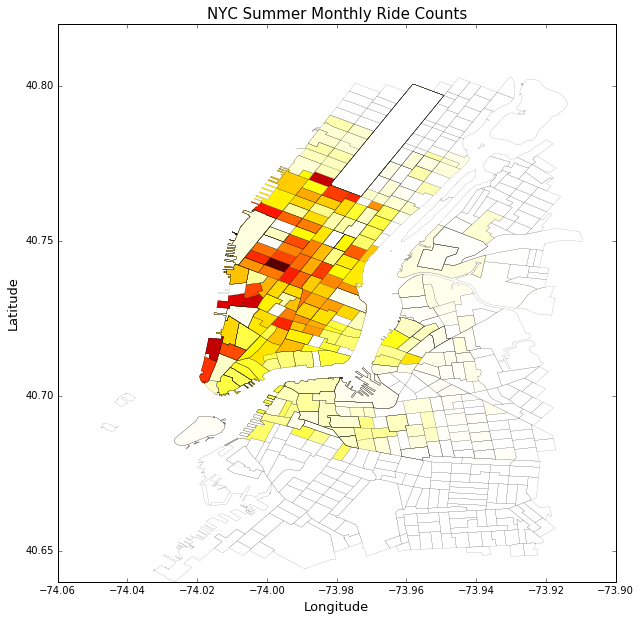

In [49]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve_Summer_Zoom=(ct_shape_MonthlyAve_Summer[ct_shape_MonthlyAve_Summer
                           .centroid
                           .apply(lambda c:c.x>-74.1 and 
                                  c.x<-73.92 and 
                                  c.y>40.65 and 
                                  c.y<40.8)])
ct_shape_MonthlyAve_Summer_Zoom.plot(column='Summer',cmap='hot_r',
                         alpha=1,linewidth=0.1,ax=ax)
plt.xlabel('Longitude', fontsize = 13)
plt.ylabel('Latitude', fontsize = 13)
plt.title("NYC Summer Monthly Ride Counts", fontsize = 15)

### Figure 6 - The above maps shows the counts of citibike riders in the Census Tracts for summer months of 2013 to 2016. It is visible that the most of the rides are in Manhattan focussed near the mid-town area.

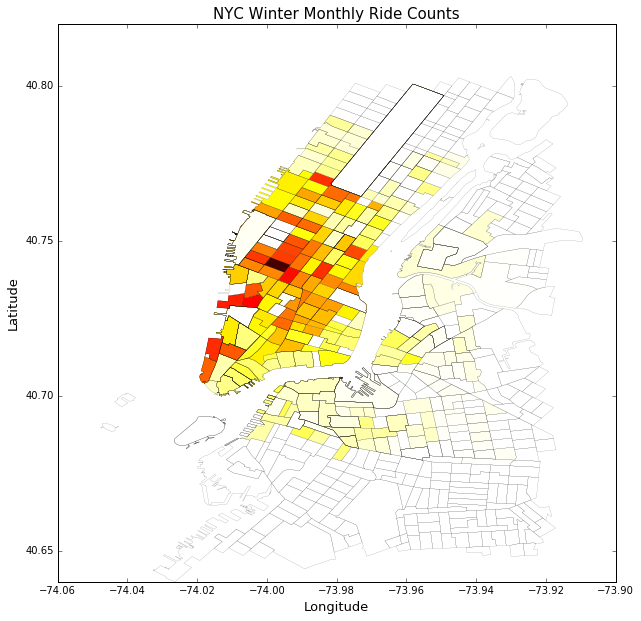

In [50]:
f, ax = plt.subplots(figsize=(10,10))
ct_shape_MonthlyAve_Winter_Zoom=(ct_shape_MonthlyAve_Winter[ct_shape_MonthlyAve_Winter
                           .centroid
                           .apply(lambda c:c.x>-74.1 and 
                                  c.x<-73.92 and 
                                  c.y>40.65 and 
                                  c.y<40.8)])
ct_shape_MonthlyAve_Winter_Zoom.plot(column='Winter',cmap='hot_r',
                         alpha=1,linewidth=0.1,ax=ax)
plt.xlabel('Longitude', fontsize = 13)
plt.ylabel('Latitude', fontsize = 13)
plt.title("NYC Winter Monthly Ride Counts", fontsize = 15)

### Figure 7 - The above maps shows the counts of citibike riders in the Census Tracts for summer months of 2013 to 2016. It is visible that the most of the rides are in Manhattan focussed near the mid-town area. The count has reduced as seen in some parts where the colour density has reduced (eg. Census Tract below the Central Park). 

In [51]:
print "Total number of CTs:", len(ct_shape)
print "Number of zoomed CTs:", len(temp.MonthlyAve)

Total number of CTs: 2166
Number of zoomed CTs: 543


### Export Shapefile CTs in the CitiBike Zone

In [53]:
path='Output/ct_shape_MonthlyAve_Zoom.shp'
path_S='Output/ct_shape_MonthlyAve_Summer_Zoom.shp'
path_W='Output/ct_shape_MonthlyAve_Winter_Zoom.shp'
ct_shape_MonthlyAve_Zoom.to_file(path)
ct_shape_MonthlyAve_Summer_Zoom.to_file(path_S)
ct_shape_MonthlyAve_Winter_Zoom.to_file(path_W)

## Exploratory Geospatial Analysis

### Spatial Weights
Contiguity: Queen Weights

In [55]:
qW_CT = ps.queen_from_shapefile(path)
qW_CTS = ps.queen_from_shapefile(path_S)
qW_CTW = ps.queen_from_shapefile(path_W)

('Island id: ', [0])
('Island id: ', [0])
('Island id: ', [0])


#### Neighbors of index10

In [56]:
qW_CT[10]

{1: 1.0, 8: 1.0, 9: 1.0, 18: 1.0, 19: 1.0, 30: 1.0, 37: 1.0, 38: 1.0, 39: 1.0}

In [57]:
qW_CT.cardinalities[10]

9

#### Matrix of Weights

In [58]:
Wmatrix, ids = qW_CT.full()
Wmatrix_summer, ids_summer = qW_CTS.full()
Wmatrix_winter, ids_winter = qW_CTW.full()

In [59]:
Wmatrix_summer
# Diagonals are all 0 as in this case, self is not neighbour or friend of self.

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1.,  0.]])

#### Change the matrix to be row-standardized

In [60]:
qW_CT.transform = 'r'
qW_CTS.transform = 'r'
qW_CTW.transform = 'r'

('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 0, ' is an island (no neighbors)')


### Spatial Lag  
Similarity of CT neibors can be meseard by means of spatial lag as follow:
$$BikeRideCountLag = \sum_j w_{i,j} BikeRideCount$$

In [62]:
MonthlyRide = ct_shape_MonthlyAve_Zoom.MonthlyAve
MonthlyRideLag = ps.lag_spatial(qW_CT, MonthlyRide)
MonthlyRide_Summer = ct_shape_MonthlyAve_Summer_Zoom.Summer
MonthlyRideLag_Summer = ps.lag_spatial(qW_CTS, MonthlyRide_Summer)
MonthlyRide_Winter = ct_shape_MonthlyAve_Winter_Zoom.Winter
MonthlyRideLag_Winter = ps.lag_spatial(qW_CTW, MonthlyRide_Winter)

#### Create Quantiles for maping

In [63]:
MonthlyRideLagQ10 = ps.Quantiles(MonthlyRideLag, k=10)
MonthlyRideLagQ10_Summer = ps.Quantiles(MonthlyRideLag_Summer, k=10)
MonthlyRideLagQ10_Winter = ps.Quantiles(MonthlyRideLag_Winter, k=10)
MonthlyRideLagQ10_Winter

                   Quantiles                   
 
  Lower              Upper                Count
            x[i] <=     0.000               159
    0.000 < x[i] <=   119.857                 2
  119.857 < x[i] <=  1876.750                78
 1876.750 < x[i] <=  4509.059                80
 4509.059 < x[i] <=  7565.413                79
 7565.413 < x[i] <= 11064.048                80
11064.048 < x[i] <= 24831.318                79
24831.318 < x[i] <= 34872.071                80
34872.071 < x[i] <= 41156.721                79
41156.721 < x[i] <= 65502.071                80

#### Map the monthly rides lag

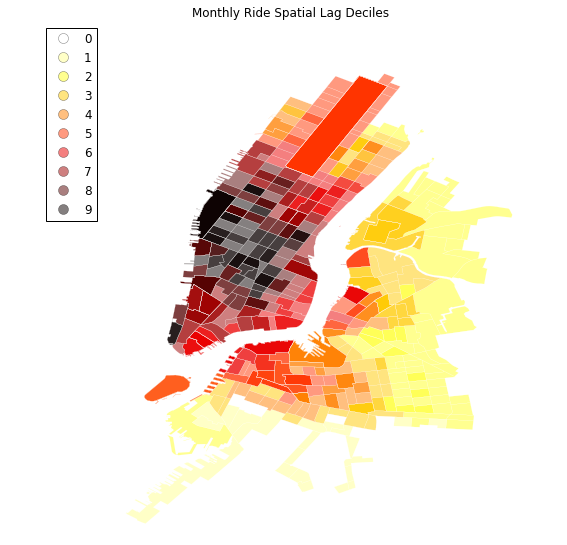

In [64]:
f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=MonthlyRideLagQ10.yb).plot(column='cl', categorical=True, 
        k=10, cmap='hot_r', linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Monthly Ride Spatial Lag Deciles")

### Figure 8 - The above map shows the spatial lag of the Citibike Rides for 2013 to 2016. 
### Note that - Governor's island is a glitch and observe that Roosevelt island has no neighbours information.

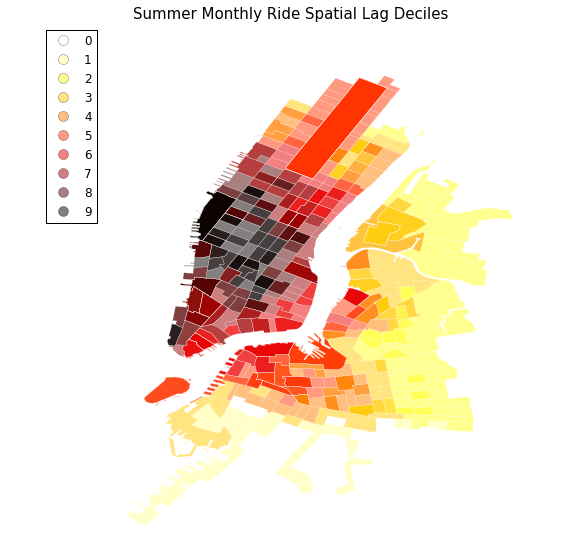

In [65]:
# Summer - 
f, ax1 = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Summer_Zoom.assign(cl=MonthlyRideLagQ10_Summer.yb).\
plot(column='cl', categorical=True, 
     k=10, cmap='hot_r', linewidth=0.1, ax=ax1, 
     edgecolor='white', legend=True)
ax1.set_axis_off()
plt.title("Summer Monthly Ride Spatial Lag Deciles", fontsize = 15)

### Figure 9 - The above map shows the spatial lag of the citibike rides for the Summer months of 2013 to 2016. 

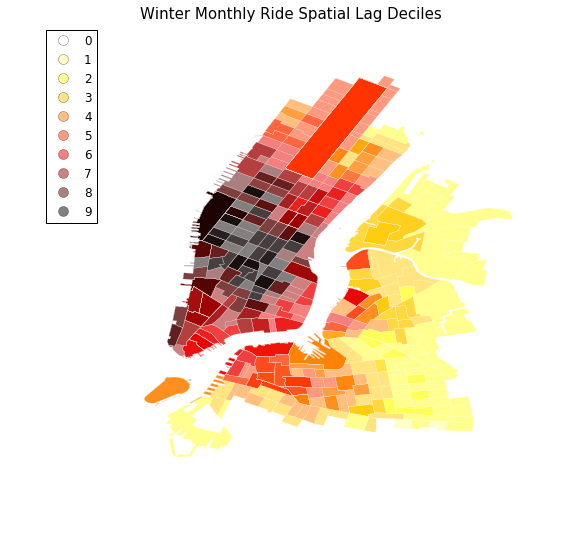

In [66]:
# Winter - 
f, ax2 = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Winter_Zoom.assign(cl=MonthlyRideLagQ10_Winter.yb).\
plot(column='cl', categorical=True, 
     k=10, cmap='hot_r', linewidth=0.1, ax=ax2, 
     edgecolor='white', legend=True)
ax2.set_axis_off()
plt.title("Winter Monthly Ride Spatial Lag Deciles", fontsize = 15)

### Figure 10 - The above map shows the spatial lag of the citibike rides for the Winter months of 2013 to 2016. 

## Global  Spatial Autocorrelation

In [72]:
b, a = np.polyfit(MonthlyRide, MonthlyRideLag, 1)
b_summer, a_summer = np.polyfit(MonthlyRide_Summer, MonthlyRideLag_Summer, 1)
b_winter,a_winter = np.polyfit(MonthlyRide_Winter, MonthlyRideLag_Winter, 1)
b_summer,a_summer

(0.64742537955062895, 7381.851004886671)

### Moran Scatterplot

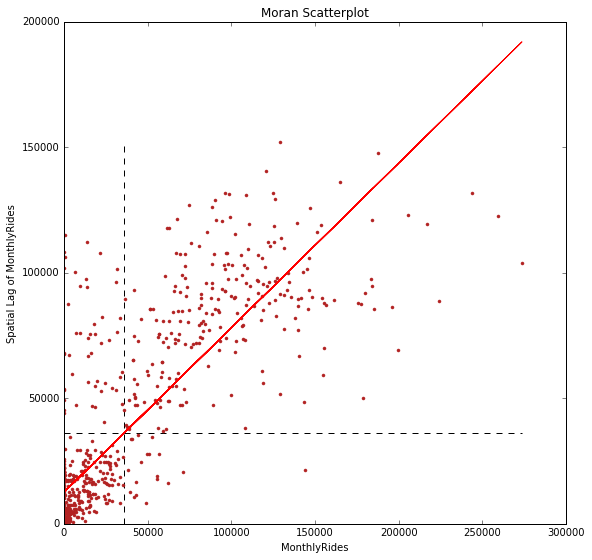

In [73]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(MonthlyRide, MonthlyRideLag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide.mean(), MonthlyRideLag.min(), MonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag.mean(), MonthlyRide.min(), MonthlyRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide, a + b*MonthlyRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')

# 4 Quadrants -> High / Low versus Ridership 

### Figure 11 - The above plot displays the Moran Scatterplot for the monthly rides for citibikes. As seen here, there is a positive spatial correlation.

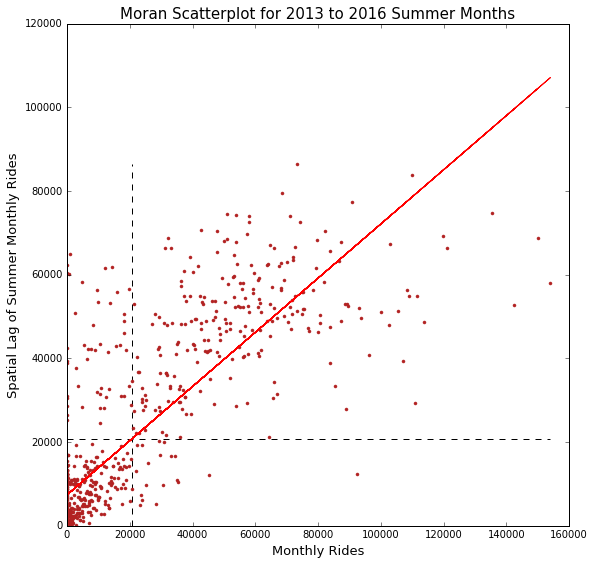

In [74]:
# Summer - 
f, ax1 = plt.subplots(1, figsize=(9, 9))

plt.plot(MonthlyRide_Summer, MonthlyRideLag_Summer, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide_Summer.mean(), MonthlyRideLag_Summer.min(), 
           MonthlyRideLag_Summer.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag_Summer.mean(), MonthlyRide_Summer.min(), 
           MonthlyRide_Summer.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide_Summer, a_summer + b_summer*MonthlyRide_Summer, 'r')
plt.title('Moran Scatterplot for 2013 to 2016 Summer Months', fontsize = 15)
plt.ylabel('Spatial Lag of Summer Monthly Rides', fontsize = 13)
plt.xlabel('Monthly Rides', fontsize = 13)

### Figure 12 - The above plot displays the Moran Scatterplot for the Monthly Rides for citibikes in Summer of 2013 to 2016. As seen here, there is a positive spatial correlation.

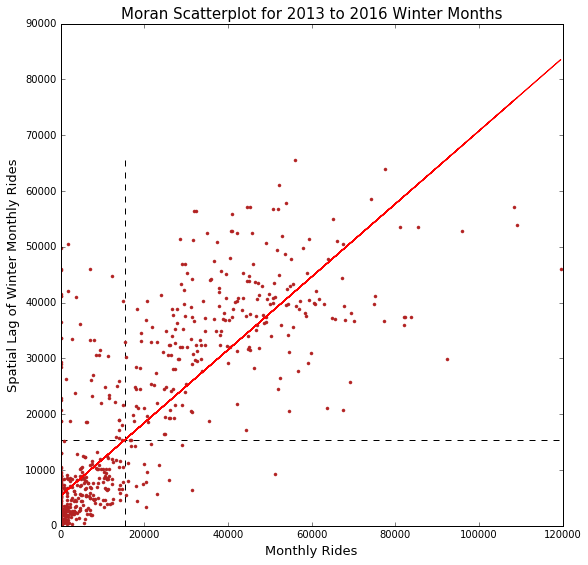

In [75]:
# Winter - 
f, ax2 = plt.subplots(1, figsize=(9, 9))

plt.plot(MonthlyRide_Winter, MonthlyRideLag_Winter, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide_Winter.mean(), MonthlyRideLag_Winter.min(),
           MonthlyRideLag_Winter.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag_Winter.mean(), MonthlyRide_Winter.min(), 
           MonthlyRide_Winter.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide_Winter, a_winter + b_winter*MonthlyRide_Winter, 'r')
plt.title('Moran Scatterplot for 2013 to 2016 Winter Months', fontsize = 15)
plt.ylabel('Spatial Lag of Winter Monthly Rides', fontsize = 13)
plt.xlabel('Monthly Rides', fontsize = 13)

### Figure 13 - The above plot displays the Moran Scatterplot for the Monthly Rides for citibikes in Winter of 2013 to 2016. As seen here, there is a positive spatial correlation.

### Moran's I

In [76]:
I_MonthlyRide = ps.Moran(MonthlyRide, qW_CT)
I_MonthlyRide_Summer = ps.Moran(MonthlyRide_Summer, qW_CTS)
I_MonthlyRide_Winter = ps.Moran(MonthlyRide_Winter, qW_CTW)

In [78]:
print 'Moran''s I - '
print 'Monthly - ',I_MonthlyRide.I, I_MonthlyRide.p_sim
print 'Summer - ', I_MonthlyRide_Summer.I, I_MonthlyRide_Summer.p_sim
print 'Winter - ', I_MonthlyRide_Winter.I, I_MonthlyRide_Winter.p_sim

Morans I - 
Monthly -  0.655793329084 0.001
Summer -  0.647577955985 0.001
Winter -  0.654312848475 0.001


Thus, the $I$ statistic greater than 0 for this data, and has a very small $p$ value. There is a spatial correlation.

In [79]:
I_MonthlyRide.sim[0:10]

array([ 0.01663388,  0.02355579,  0.00773043,  0.01015249,  0.00729673,
       -0.0422863 , -0.00389895, -0.00747516, -0.0238221 , -0.0156526 ])

### KDEplot of all of the simulated points
the vertical line shows the observed value

In [80]:
import seaborn as sns
plt.rcParams['figure.figsize']=(14,3)

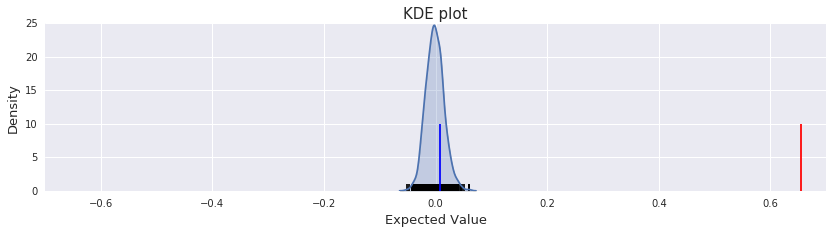

In [81]:
sns.kdeplot(I_MonthlyRide.sim, shade=True)
plt.vlines(I_MonthlyRide.sim, 0, 1)
plt.vlines(I_MonthlyRide.I, 0, 10, 'r')
plt.vlines(I_MonthlyRide.EI+.01, 0, 10, 'blue')
plt.xlim([-.70, .70])
plt.title('KDE plot', fontsize = 15)
plt.xlabel('Expected Value', fontsize = 13)
plt.ylabel('Density', fontsize = 13)

### Figure 14 - The vertical line is showing if our $I$ statistic (red line) is away from our expected $I$ (blue line) value under normality assumption

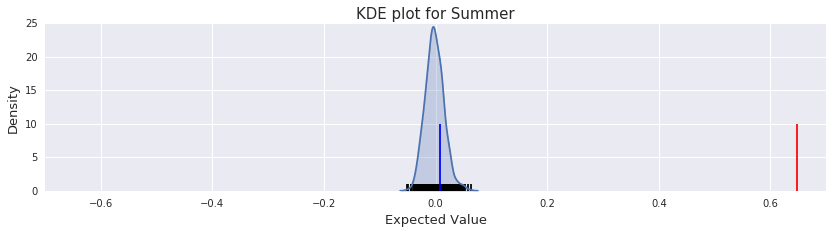

In [82]:
# Summer - 
sns.kdeplot(I_MonthlyRide_Summer.sim, shade=True)
plt.vlines(I_MonthlyRide_Summer.sim, 0, 1)
plt.vlines(I_MonthlyRide_Summer.I, 0, 10, 'r')
plt.vlines(I_MonthlyRide_Summer.EI+.01, 0, 10, 'blue')
plt.xlim([-.70, .70])
plt.title('KDE plot for Summer', fontsize = 15)
plt.xlabel('Expected Value', fontsize = 13)
plt.ylabel('Density', fontsize = 13)

### Figure 15 - In the above figure the vertical line is showing that our $I$ statistic (red line) for summer months is away from our expected $I$ value (blue line) under normality assumption

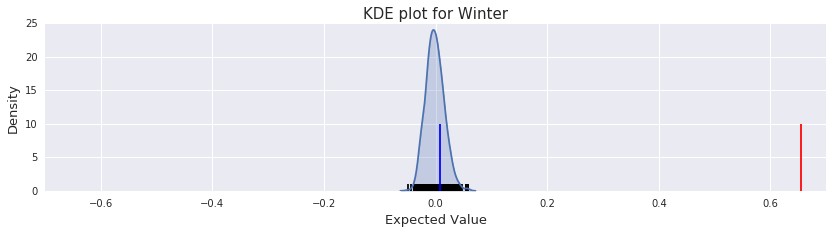

In [83]:
# Winter - 
sns.kdeplot(I_MonthlyRide_Winter.sim, shade=True)
plt.vlines(I_MonthlyRide_Winter.sim, 0, 1)
plt.vlines(I_MonthlyRide_Winter.I, 0, 10, 'r')
plt.vlines(I_MonthlyRide_Winter.EI+.01, 0, 10, 'blue')
plt.xlim([-.70, .70])
plt.title('KDE plot for Winter', fontsize = 15)
plt.xlabel('Expected Value', fontsize = 13)
plt.ylabel('Density', fontsize = 13)

### Figure 16 - In the above figure the vertical line is showing that our $I$ statistic (red line) for winter months is away from our expected $I$ value (blue line) under normality assumption

## Local  Spatial Autocorrelation

In [84]:
LMo_MonthlyRide = ps.Moran_Local(MonthlyRide, qW_CT,permutations=999)
LMo_MonthlyRide_Summer = ps.Moran_Local(MonthlyRide_Summer, qW_CTS,permutations=999)
LMo_MonthlyRide_Winter = ps.Moran_Local(MonthlyRide_Winter, qW_CTW,permutations=999)

In [85]:
LMo_MonthlyRide_Winter.Is[0:5], LMo_MonthlyRide_Winter.p_sim[0:5]

(array([ -0.00000000e+00,  -2.54289768e-01,  -8.49562917e-04,
          1.12122005e-04,  -2.93415998e-02]),
 array([ 0.001,  0.164,  0.463,  0.45 ,  0.457]))

### LISA (Local Indicators of Spatial Autocorrelation)

In [86]:
sigs = MonthlyRide[LMo_MonthlyRide.p_sim <= .001]
W_sigs = MonthlyRideLag[LMo_MonthlyRide.p_sim <= .001]
insigs = MonthlyRide[LMo_MonthlyRide.p_sim > .001]
W_insigs = MonthlyRideLag[LMo_MonthlyRide.p_sim > .001]

sigs_summer = MonthlyRide_Summer[LMo_MonthlyRide_Summer.p_sim <= .001]
W_sigs_summer = MonthlyRideLag_Summer[LMo_MonthlyRide_Summer.p_sim <= .001]
insigs_summer = MonthlyRide_Summer[LMo_MonthlyRide_Summer.p_sim > .001]
W_insigs_summer = MonthlyRideLag_Summer[LMo_MonthlyRide_Summer.p_sim > .001]

sigs_winter = MonthlyRide_Winter[LMo_MonthlyRide_Winter.p_sim <= .001]
W_sigs_winter = MonthlyRideLag_Winter[LMo_MonthlyRide_Winter.p_sim <= .001]
insigs_winter = MonthlyRide_Winter[LMo_MonthlyRide_Winter.p_sim > .001]
W_insigs_winter = MonthlyRideLag_Winter[LMo_MonthlyRide_Winter.p_sim > .001]

### Plot Signficant LISA

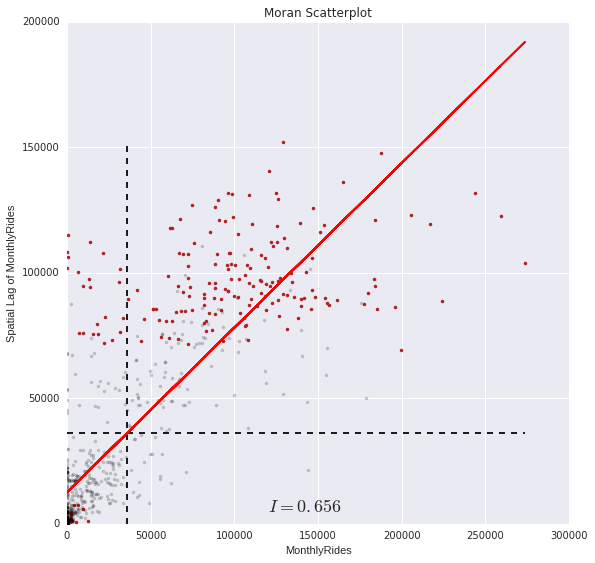

In [87]:
f, ax = plt.subplots(figsize=(9, 9))
plt.plot(sigs, W_sigs, '.', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_MonthlyRide.I, x=120000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide.mean(), MonthlyRideLag.min(), MonthlyRideLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag.mean(), MonthlyRide.min(), MonthlyRide.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide, a + b*MonthlyRide, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of MonthlyRides')
plt.xlabel('MonthlyRides')


### Figure 17 - Above figures is for Moran's Scatterplot and it shows a positive spatial correlation.

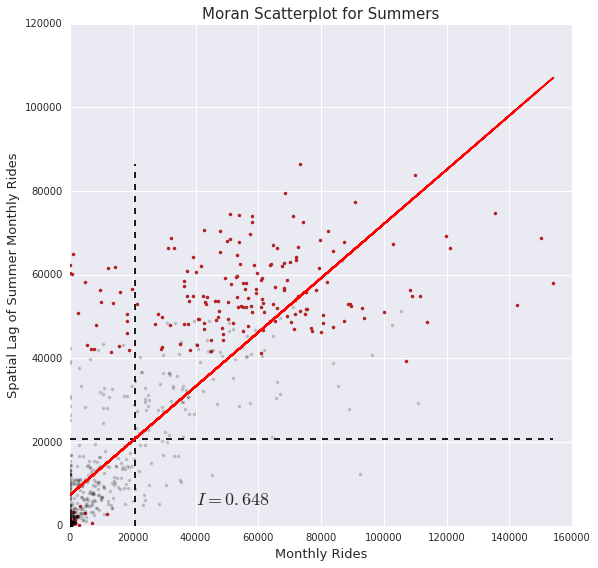

In [88]:
f, ax1 = plt.subplots(figsize=(9, 9))
plt.plot(sigs_summer, W_sigs_summer, '.', color='firebrick')
plt.plot(insigs_summer, W_insigs_summer, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_MonthlyRide_Summer.I, x=40000, y=5000, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide_Summer.mean(), MonthlyRideLag_Summer.min(), 
           MonthlyRideLag_Summer.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag_Summer.mean(), MonthlyRide_Summer.min(), 
           MonthlyRide_Summer.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide_Summer, a_summer + b_summer*MonthlyRide_Summer, 'r')
plt.title('Moran Scatterplot for Summers', fontsize = 15)
plt.ylabel('Spatial Lag of Summer Monthly Rides', fontsize = 13)
plt.xlabel('Monthly Rides', fontsize = 13)

### Figure 18 - Above figures is for Moran's Scatterplot for summer months of 2013 to 2016. It shows a positive spatial correlation.

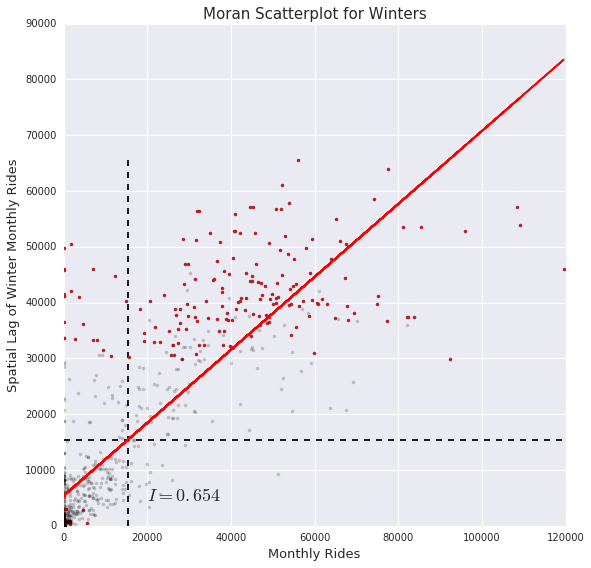

In [89]:
f, ax2 = plt.subplots(figsize=(9, 9))
plt.plot(sigs_winter, W_sigs_winter, '.', color='firebrick')
plt.plot(insigs_winter, W_insigs_winter, '.k', alpha=.2)
plt.text(s='$I = %.3f$' % I_MonthlyRide_Winter.I, x=20000, y=4500, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(MonthlyRide_Winter.mean(), MonthlyRideLag_Winter.min(), 
           MonthlyRideLag_Winter.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(MonthlyRideLag_Winter.mean(), MonthlyRide_Winter.min(), 
           MonthlyRide_Winter.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(MonthlyRide_Winter, a_winter + b_winter*MonthlyRide_Winter, 'r')
plt.title('Moran Scatterplot for Winters', fontsize = 15)
plt.ylabel('Spatial Lag of Winter Monthly Rides', fontsize = 13)
plt.xlabel('Monthly Rides', fontsize = 13)

### Figure 19 - Above figures is for Moran's Scatterplot for winter months of 2013 to 2016. It shows a positive spatial correlation.

### Hot and Cold spots 

In [93]:
sig = LMo_MonthlyRide.p_sim < 0.01
hotspots = LMo_MonthlyRide.q==1 * sig    # Quartile = 1
coldspots = LMo_MonthlyRide.q==3 * sig    # Quartile = 3
print "Number of Hotspots:", hotspots.sum()
print "Number of Coldspots:", coldspots.sum()

Number of Hotspots: 190
Number of Coldspots: 238


In [94]:
# Summer -
sig_summer = LMo_MonthlyRide_Summer.p_sim < 0.01
hotspots_summer = LMo_MonthlyRide_Summer.q==1 * sig_summer
coldspots_summer = LMo_MonthlyRide_Summer.q==3 * sig_summer
print "Number of Summer Hotspots:", hotspots_summer.sum()
print "Number of Summer Coldspots:", coldspots_summer.sum()

Number of Summer Hotspots: 190
Number of Summer Coldspots: 238


In [92]:
# Winter - 
sig_winter = LMo_MonthlyRide_Winter.p_sim < 0.01
hotspots_winter = LMo_MonthlyRide_Winter.q==1 * sig_winter
coldspots_winter = LMo_MonthlyRide_Winter.q==3 * sig_winter
print "Number of Winter Hotspots:", hotspots_winter.sum()
print "Number of Winter Coldspots:", coldspots_winter.sum()

Number of Winter Hotspots: 192
Number of Winter Coldspots: 215


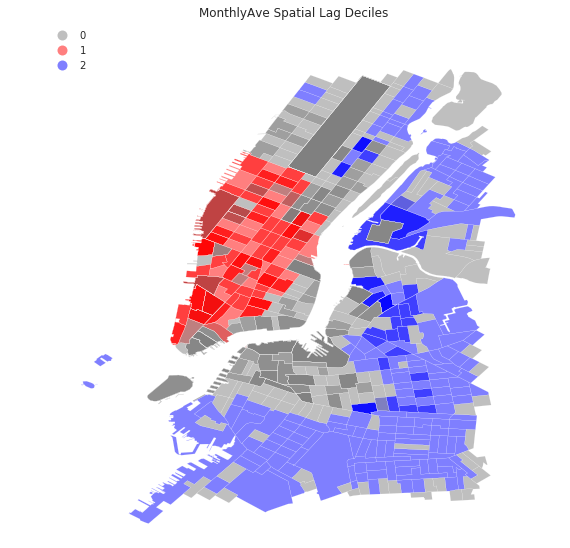

In [96]:
from matplotlib import colors

hcmap = colors.ListedColormap(['grey','red','blue'])
hotcold = hotspots*1 + coldspots*2
# hotspots and coldspots are complimentary of each other.
# Gives either 0 or 1 or 2

f, ax = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Zoom.assign(cl=hotcold).plot(column='cl', categorical=True, 
        k=10, cmap=hcmap, linewidth=0.1, ax=ax, 
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("MonthlyAve Spatial Lag Deciles")


### Figure 20 - The map shows the Cold spots and Hot spots of the citibike rides. It is visible that high rides CT's are closer to each other.

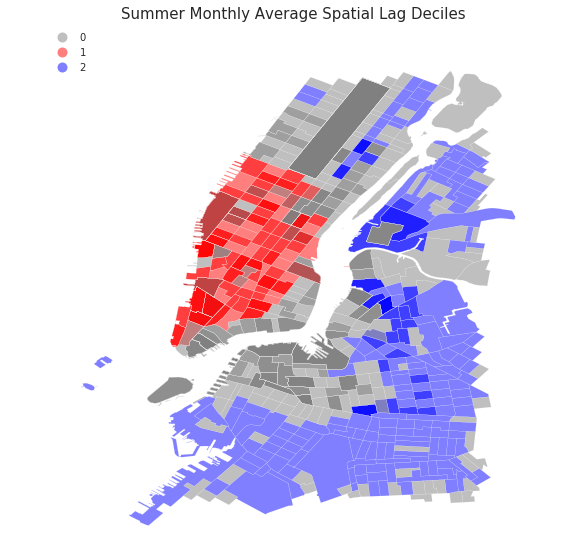

In [97]:
# Summer - 
hcmap_summer = colors.ListedColormap(['grey','red','blue'])
hotcold_summer = hotspots_summer*1 + coldspots_summer*2

f, ax1 = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Summer_Zoom.assign(cl=hotcold_summer).plot(column='cl', 
         categorical=True, 
         cmap=hcmap_summer, linewidth=0.1, ax=ax1, 
         edgecolor='white', legend=True)
ax1.set_axis_off()
plt.title("Summer Monthly Average Spatial Lag Deciles", fontsize = 15)

### Figure 21 - The map shows the Cold spots and Hot spots of the citibike rides for the summer months. Blue color is for cold spots and red is for hotspots.

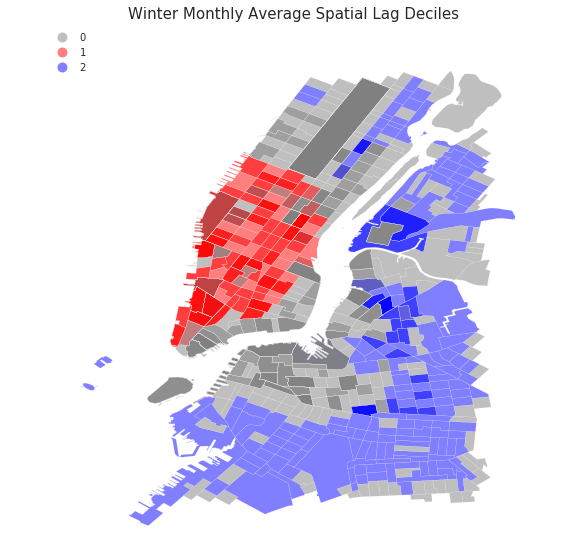

In [98]:
# Winter - 
hcmap_winter = colors.ListedColormap(['grey','red','blue'])
hotcold_winter = hotspots_winter*1 + coldspots_winter*2

f, ax2 = plt.subplots(figsize=(9, 9))
ct_shape_MonthlyAve_Winter_Zoom.assign(cl=hotcold_winter).plot(column='cl', 
         categorical=True, 
         cmap=hcmap_winter, linewidth=0.1, ax=ax2, 
         edgecolor='white', legend=True)
ax2.set_axis_off()
plt.title("Winter Monthly Average Spatial Lag Deciles", fontsize = 15)

### Figure 22 - The map shows the Cold spots and Hot spots of the citibike rides for the summer months. Blue color is for cold spots and red is for hotspots.